### Download and prepare data

In this notebook, we are going to download the data that is required to conduct the analysis of the health facilities accessibility. The data includes the following:
- Administrative boundaries of a country at level 2 (second sub-national level) from the <i>GADM Database of Global Administrative Areas</i>
- Health care location data from <i>healthsites.io</i>
- Distribution of the population as the spatial raster dataset from <i>European Commission Global Human Settlement GHS-POP dataset </i>

Subsequently, the health facilities dataset will be filtered in terms of the distances between particular locations, decreasing the total number and density of health facilities. Next step is to clip the World population dataset raster to the boundaries corresponding to the country of interest and reproject it to EPSG:4326 coordinate system. If we would like to use the <i>OSMNX</i> library to compute the isolines of accessibility, then we have to create the Graphml object using one of the three approaches: 
- Convert shapefile to OSM format using <i>ogr2osm</i>, then create Graphml file with <i>ox.graph_from_xml()</i>
- Create Graphml from OSM using <i>ox.graph_from_xml()</i>
- Use <i>ox.graph_from_place()</i> method to download data from <i>Overpass API</i> and create Graphml object

The process of creating a Graphml object can take up to several hours!

Data is going to be stored in a folder structure according to the following template:

{Country_name}/<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;├── Administrative_boundaries/<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;├── Health_facilities/<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;├── Population/<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;└── Roads/<br>


We will begin with importing all indispensable libraries that will be used in this notebook.

In [1]:
import osmnx as ox
import subprocess
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import box
import json
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import pycrs
import ipywidgets as widgets
from IPython.display import display
import os
import urllib
from urllib.error import HTTPError
from zipfile import ZipFile
from utilities import country_codes

Now we can execute the code in the following cell and chose the country of interest from the drop-down list. If the desired country isn't included in the list, it means that there is no available data for that country.

In [2]:
country_list = widgets.Dropdown(
    options=list(country_codes.keys()),
    description='Country:',
    disabled=False,
)

display(country_list)

Dropdown(description='Country:', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla'…

#### Administrative boundaries level 2

To find the administrative boundaries of the specified country in <i>GADM</i> database we have to provide its <i>ISO 3166 alpha-3</i> code to the request URL. You can read more about the aforementioned codes under the following link: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3

In [3]:
country_alpha3_code = country_codes.get(country_list.value)

Now we will create the directory structure for the chosen country.

In [4]:
# Create directory structure for given country
if not os.path.exists(country_list.value):
    for sub_dir in ["Administrative_boundaries", "Health_facilities", "Roads", "Population"]:
        try:
            os.makedirs(os.path.join(country_list.value, sub_dir))
        except OSError as message:
            print(message)

Below we will download ZIP file containing Geopackage file of the administrative boundaries and extract it to the <i>{Country_name}/Administrative_boundaries</i> directory.

In [5]:
adm_bound_file_name = "gadm36_" + country_alpha3_code + "_gpkg.zip"
adm_bound_file_path = os.path.join(country_list.value, "Administrative_boundaries", adm_bound_file_name)

if not os.path.exists(adm_bound_file_path):
    try:
        # Download administrative boundaries Geopackage file from https://gadm.org
        url = "https://biogeo.ucdavis.edu/data/gadm3.6/gpkg/" + adm_bound_file_name
        urllib.request.urlretrieve(url, adm_bound_file_path)

        with ZipFile(adm_bound_file_path, 'r') as zip_ref:
           # Extract all the contents of zip file
           zip_ref.extractall(os.path.join(country_list.value, "Administrative_boundaries"))
            
        print("Download of " + adm_bound_file_name + " completed.")
            
    except HTTPError as error:
        print(error)

#### Health facilities

Now we will download the health facilities data as a ZIP file from the <i>healthsites.io</i> API, then this file will be extracted directly to <i>{Country_name}/Health_facilities</i> directory.

In [4]:
health_fac_file_name = country_list.value + ".zip"
health_fac_file_path = os.path.join(country_list.value, "Health_facilities", health_fac_file_name)

if not os.path.exists(health_fac_file_path):
    try:
        # Download Health facilities shapefile from healthsites.io API
        url = "https://healthsites.io/api/v2/facilities/shapefile/{}/download".format(country_list.value)
        
        opener = urllib.request.build_opener()
        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
        urllib.request.install_opener(opener)
        urllib.request.urlretrieve(url, health_fac_file_path)

        print("Download of " + health_fac_file_name + " completed")
        
        with ZipFile(health_fac_file_path, 'r') as zip_ref:
            # Extract all the contents of zip file
            zip_ref.extractall(os.path.join(country_list.value, "Health_facilities"))
            
    except HTTPError as error:
        print(error)

#### Filter health facilities and fill out address information

Let's begin with importing required dataset. We can use the <i>Geopandas</i> library to read the health facilities shapefile.

In [4]:
health_nodes_file_path = os.path.join(country_list.value, "Health_facilities", "{}-node.shp".format(country_list.value))
health_nodes = gpd.read_file(health_nodes_file_path)

Now we are able to see for the first time how our dataset looks like. Let's inspect first 5 rows.

In [5]:
health_nodes.head()

,osm_id,amenity,healthcare,name,operator,source,speciality,operator_ty,contact_num,operational,...,url,addr_housen,addr_street,addr_postco,addr_city,changeset_i,changeset_v,changeset_t,changeset_u,geometry
0,1482030011,pharmacy,None,Farmatodo,None,None,None,None,None,None,...,None,None,None,None,None,9665341,1,2011-10-27 03:41:15,jCGd1983,POINT (-71.64681 10.55716)
1,1482020270,pharmacy,None,Farmacia La Social,None,None,None,None,None,None,...,None,None,None,None,None,76238405,3,2019-10-26 09:22:18,Eliomarnm,POINT (-71.63249 10.57539)
2,1500082407,pharmacy,None,Farmacia 24 Horas,None,None,None,None,None,None,...,None,None,None,None,None,31066024,2,2015-05-12 20:31:32,Arquitectónico,POINT (-71.14639 8.59236)
3,1500875045,pharmacy,None,Farmacia Yamilet,None,None,None,None,None,None,...,None,None,Calle 9,4147,Judibana,47643546,2,2017-04-11 02:25:51,rirausquin,POINT (-70.18066 11.75917)
4,1502246171,pharmacy,None,Centro Medico Cagua,None,None,None,None,None,None,...,None,None,None,None,None,9820062,1,2011-11-13 22:34:47,Rafael Pernia,POINT (-67.45612 10.18978)


As we can see, there is a lot of missing information in <i>addr_street</i> column. Thus, we will use the <i>Geopy</i> library to find the address corresponding to health facility coordinates. The <i>Geopy.Nominatim</i> is a geocoder for <i>OpenStreetMap</i> data, it is free, but provides low request limit, that's why we have to use the <i>geopy.extra.rate_limit.RateLimiter</i> method to handle error responses and add delays when needed.

In [6]:
geolocator = Nominatim(user_agent="health_facility_address")
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

counter = 0

for idx, row in health_nodes.iterrows():
    lat, long = row.geometry.y, row.geometry.x
    coord = "{}, {}".format(lat, long)
    address = row.addr_street
    if not address:
        health_nodes.loc[idx, 'addr_street'] = geocode(coord).address
        counter += 1
        
print('Added {} new addresses'.format(counter))

Added 1222 new addresses


Now we can display the <i>addr_street</i> column with some new addresses added.

In [7]:
health_nodes.addr_street.head()

0    Farmatodo, Avenida 48, San Francisco, Parroqui...
1    Farmacia La Social, Av 18, San Francisco, Parr...
2    Farmacia 24 Horas, Paseo de La Feria, Mérida, ...
3                                              Calle 9
4    Centro Médico Cagua, Avenida 02 Bermúdez, Sant...
Name: addr_street, dtype: object

Save the data frame with new addresses.

In [9]:
new_health_file_path = os.path.join(country_list.value, "Health_facilities", "{}-node.gpkg".format(country_list.value))
health_nodes.to_file(driver='GPKG', filename=new_health_file_path)

By using <i>.crs</i> attribute we can check the Coordinate Reference System (CRS) of a dataset.

In [9]:
health_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we can plot the health facilities dataset to visualize the spatial distribution of data points.

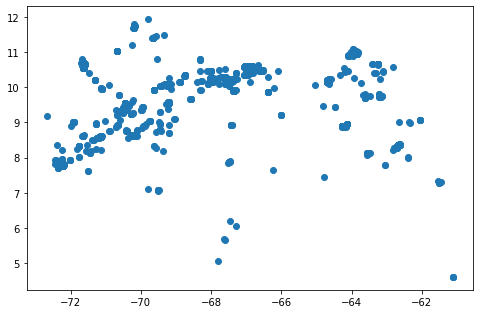

In [10]:
health_nodes.plot(figsize=(8,8))

The following method counts the number of times given <i>amenity</i> type occurred in the dataset.

In [11]:
health_nodes.amenity.value_counts()

pharmacy      1091
hospital       411
clinic         232
doctors        153
dentist         24
laboratory       1
Name: amenity, dtype: int64

The above tally shows the distribution of the types of health facilities. Usually, we will treat the <i>hospital</i> as the most important health care facility and remove other types of facilities that are located in the neighborhood. In that case, the isoline of health care access will be calculated for our primary facility - <i>hospital</i>. If the number of hospitals is the order of magnitude lower than any other type of facility, then there will be a situation when there is no <i>hospital</i> at given area and health care access isoline will be computed with respect to another less important facility, for example, <i>pharmacy</i>. 

If you would like to retain only the <i>hospitals</i> for further analysis, then uncomment the following code, otherwise, skip it and go to the next cells.

In [7]:
# filtered_df = health_nodes.loc[health_nodes.amenity == 'hospital']

Below we will define a function that returns boolean value (True or False) depending on whether two health facilities lie within a specific radius from each other.

In [21]:
def within_distance(point, data_frame, distance, to_itself=False):
    """Returns True if 'point' lies within a distance of any data point in 'data_frame', otherwise returns False.
    
    Parameters
    ----------
    point: shapely.geometry.point.Point
        Shapely point object representing the health facility.
    data_frame: geopandas.geodataframe.GeoDataFrame
        Geopandas Data Frame object of health facilities (must contain 'geometry' column).
    distance: int
        Distance in meters.
    to_itself: boolean, optional (default=False)
        whether the distance condition is checked also for point itself - if 'point' is also included in 'data_frame', 
        beacause we don't want to compare 'point' to itself, then the counter must be > 1 to return True.
        
    Returns
    -------
    boolean: 
        True or False depending on whether two health facilities lie within a specific distance from each other.
    
    Raises
    ------
    AssertionError 
        If data_frame doesn't contain 'geometry' column.
        
    """
    
    assert 'geometry' in data_frame.columns, "Data Frame doesn't contain 'geometry' column."
    
    # Create circle buffer from one of the points
    circle_buffer = point.geometry.buffer(distance)
    counter = 0
    
    for row in data_frame.itertuples():
        # Check if the other point lies within circle_buffer
        if row.geometry.within(circle_buffer):
            if to_itself:
                counter += 1
                if counter == 2:
                    return True
            else:
                return True
        else:
            continue
            
    return False

In order to reduce density and number of health facilities in the dataset (simultaneously decreasing the number of required isolines), we are going to implement the filtering function that follows the succeeding steps:
1. Filter out primary facilities that are within distance to other primary facilities.
2. Filter out other not-primary facilities that are within distance to primary facilities (from step 1).
3. Filter out not-primary facilities that are within distance to other not-primary facilities (from step 2).
 - Filter out close facilities of the same type.
 - Filter out close facilities of the other type.

In [22]:
def filter_facilities_within_distance(data_frame, distance, primary_field="hospital"):
    """Filters out health facilities from 'data_frame' that are within a certain 'distance' to other health facilities,
    keeping priority to being retained by the facility specified by the 'primary_field' parameter.
    
    Parameters
    ----------
    data_frame: geopandas.geodataframe.GeoDataFrame
        Geopandas Data Frame object of health facilities (must contain 'geometry', 'amenity' and 'healthcare' columns).
    distance: int
        Distance in meters.
    primary_field: str, optional (default='hospital')
        Type of the primary health facility, that has the precedence over other facilities to be retained in the dataset.
    
    Returns
    -------
    data_frame: geopandas.geodataframe.GeoDataFrame
        Geopandas Data Frame object of filtered health facilities.
    
    Raises
    ------
    AssertionError 
        If data_frame doesn't contain even one of the following columns: 'geometry', 'amenity', 'healthcare'. 
        
    """
    
    # Check whether DF contains indispensable columns
    df_columns = list(data_frame.columns)
    assert "amenity" in df_columns, "Data Frame doesn't contain 'amenity' column."
    assert "healthcare" in df_columns, "Data Frame doesn't contain 'healthcare' column."
    assert "geometry" in df_columns, "Data Frame doesn't contain 'geometry' column."
    
    # Find the indexes of NaN amenity values
    isNaN = data_frame.loc[:, "amenity"].isna()
    na_idx = data_frame.loc[isNaN].index
    
    # Replace NaN amenity values with healthcare values
    data_frame.loc[na_idx, "amenity"] = data_frame.loc[na_idx, "healthcare"]
    
    # Drop any remaining rows with NaN amenity value
    isNaN = data_frame.loc[:, "amenity"].isna()
    na_idx = data_frame.loc[isNaN].index
    data_frame.drop(na_idx, inplace=True)
    
    # Take the list of all facilities types
    facility_types = list(data_frame.loc[:, "amenity"].unique())
    
    # Separate facilities and project resulting DFs to WGS 84 / Pseudo-Mercator (meters)
    primary_field_df = data_frame.loc[data_frame.amenity == primary_field].copy().to_crs("EPSG:4978")
    rest_df = data_frame.loc[data_frame.amenity != primary_field].copy().to_crs("EPSG:4978")
    
    # Filter out primary facilities that are within distance to other primary facilities
    primary_field_df["within_{}m".format(distance)] = primary_field_df.apply(within_distance,
                                                                             data_frame=primary_field_df,
                                                                             distance=distance,
                                                                             to_itself=True,
                                                                             axis=1)
    
    primary_to_remove_idx = primary_field_df.loc[primary_field_df["within_{}m".format(distance)] == True].index
    
    # Drop filtered facilities
    data_frame.drop(primary_to_remove_idx, inplace=True)
    primary_field_df.drop(primary_to_remove_idx, inplace=True)
    
    # Filter out other facilities that are within distance to primary facilities
    rest_df["within_{}m".format(distance)] = rest_df.apply(within_distance,
                                                           data_frame=primary_field_df,
                                                           distance=distance,
                                                           axis=1)
    
    rest_to_remove_idx = rest_df.loc[rest_df["within_{}m".format(distance)] == True].index
    
    # Drop filtered facilities
    data_frame.drop(rest_to_remove_idx, inplace=True)
    rest_df.drop(rest_to_remove_idx, inplace=True)
    
    # Filter out not-primary facilities that are within distance to other not-primary facilities
    facility_types.remove(primary_field)
    
    for facility in facility_types:
        facility_df = rest_df.loc[rest_df.amenity == facility].copy()
        
        #  Filter out close facilities of the same type
        facility_df["within_{}m".format(distance)] = facility_df.apply(within_distance,
                                                                       data_frame=facility_df,
                                                                       distance=distance,
                                                                       to_itself=True,
                                                                       axis=1)
        
        to_remove_idx = facility_df.loc[facility_df["within_{}m".format(distance)] == True].index
        
        data_frame.drop(to_remove_idx, inplace=True)
        rest_df.drop(to_remove_idx, inplace=True)
        facility_df.drop(to_remove_idx, inplace=True)
        facility_df.drop(columns="within_{}m".format(distance), inplace=True)
        
        not_facility_df = rest_df.loc[rest_df.amenity != facility].copy()
        
        #  Filter out close facilities of the other type
        facility_df["within_{}m".format(distance)] = facility_df.apply(within_distance,
                                                                       data_frame=not_facility_df,
                                                                       distance=distance,
                                                                       axis=1)
    
        to_remove_idx = facility_df.loc[facility_df["within_{}m".format(distance)] == True].index
        
        data_frame.drop(to_remove_idx, inplace=True)
        
        del facility_df
        del not_facility_df

    return data_frame        
        

Below we will run the filtering function and assign the resulting Data Frame to a new variable.

In [23]:
filtered_df = filter_facilities_within_distance(health_nodes, distance=2000, primary_field="hospital")

Now we can check how the distribution of the types of health facilities looks like in a filtered Data Frame.

In [24]:
filtered_df.amenity.value_counts()

hospital       107
pharmacy        29
clinic          16
doctors          8
laboratory       5
dentist          1
doctor           1
alternative      1
Name: amenity, dtype: int64

The following plot shows the spatial distribution of health facilities in filtered Data Frame. As we can see, there are fewer data points that overlap themselves (it can be much better discernable at higher zoom levels).

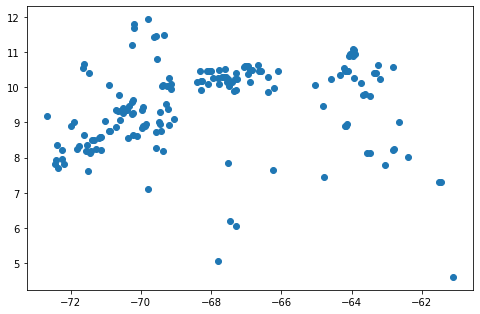

In [13]:
filtered_df.plot(figsize=(8,8))

The resulting Data Frame with filtered health care facilities subsequently will be saved on a disk as a Geopackage file.

In [25]:
filtered_file_path = os.path.join(country_list.value, "Health_facilities", "{}-filtered-node.gpkg".format(country_list.value))
filtered_df.to_file(driver='GPKG', filename=filtered_file_path)

#### Population data

We will download the Global population data from the <i>European Commission Global Human Settlement</i> website as the spatial raster that depicts the distribution and density of the population expressed as the number of people per cell. The technical details about the data are as follows:
- Coordinate System: World Mollweide (EPSG: 54009)
- Population density for epoch 2015
- 250 m resolution
- The grids are provided as GeoTIFF file

In [18]:
if not os.path.exists("World_population_data"):
    os.mkdir("World_population_data")
if not os.path.exists("World_population_data/world_population_raster.zip"):
    try:
        # Download population data from ghsl.jrc.ec.europa.eu
        url = "https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_MT_GLOBE_R2019A/"\
        "GHS_POP_E2015_GLOBE_R2019A_54009_250/V1-0/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0.zip"
        urllib.request.urlretrieve(url, "World_population_data/world_population_raster.zip")

        with ZipFile("World_population_data/world_population_raster.zip", 'r') as zip_ref:
           # Extract all the contents of zip file
           zip_ref.extractall(os.path.join("World_population_data"))
            
        print("Download of population data completed.")
            
    except HTTPError as error:
        print(error)

The Global population data raster has been saved to <i>World_population_data/</i> directory.

In [11]:
world_pop_file_path = ""
for file in os.listdir("World_population_data"):
    if file.endswith(".tif"):
        world_pop_file_path = os.path.join("World_population_data", file)

Below we will use the <i>rasterio</i> library to open the GeoTIFF file and then clip it to the bounding box corresponding to the country of interest.

In [12]:
world_pop = rasterio.open(world_pop_file_path)

We will begin with checking the Coordinate Reference System.

In [13]:
world_pop.crs.data

{'proj': 'moll',
 'lon_0': 0,
 'x_0': 0,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

We have to open the file containing administrative boundaries in order to create a bounding box of area of interest.

In [22]:
adm_bound_file_name = "gadm36_" + country_alpha3_code + ".gpkg"
adm_bound_file_path = os.path.join(country_list.value, "Administrative_boundaries", adm_bound_file_name)

adm_boundaries = gpd.read_file(adm_bound_file_path)

In [23]:
adm_boundaries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

To get the bounding box we can use the <i>.total_bounds</i> attribute of <i>geopandas</i> Data Frame.

In [24]:
minx, miny, maxx, maxy = adm_boundaries.total_bounds

Next, we need to create a bounding box with <i>shapely</i> library.

In [25]:
bbox = box(minx, miny, maxx, maxy)

Then, the <i>shapely</i> bounding box object should be inserted into a GeoDataFrame.

In [26]:
bbox = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=adm_boundaries.crs)

The bounding box must be reprojected into the same coordinate system as the raster data.

In [27]:
bbox = bbox.to_crs(crs=world_pop.crs.data)

As expected the bounding box is now projected using the <i>Mollweide</i> coordinate system.

In [28]:
bbox.crs

<Projected CRS: +proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +un ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Mollweide
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Next we need to get the coordinates of the bounding box geometry in such a format that <i>rasterio</i> wants them. This can be achieved with the following function.

In [29]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [30]:
bbox_coords = getFeatures(bbox)

Using the <i>mask</i> function from <i>rasterio</i> we can clip the raster with the polygon specified by <i>bbox_coords</i> variable.

In [31]:
out_img, out_transform = mask(dataset=world_pop, shapes=bbox_coords, crop=True)

Next we have to update the metadata of the clipped raster.

In [32]:
out_meta = world_pop.meta.copy()

In [33]:
# World Mollweide projection, EPSG:54009
epsg_code = 54009

out_meta.update({"driver": "GTiff",
                "height": out_img.shape[1],
                "width": out_img.shape[2],
                "transform": out_transform,
                "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

Save the clipped raster to disk.

In [34]:
population_raster_path = os.path.join(country_list.value, "Population", "{}-population.tif".format(country_list.value))

In [35]:
with rasterio.open(population_raster_path, "w", **out_meta) as dest:
    dest.write(out_img)

Finally, we can open the population dataset of the country of interest and see for the first time how it looks like.

In [36]:
population_dataset = rasterio.open(population_raster_path)

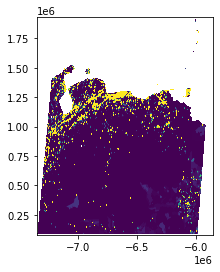

In [37]:
show(population_dataset, cmap="viridis", vmax=0.5)

#### Reproject the population raster to EPSG:4326

We must ensure that all data that we use in our analysis share the same Coordinate Reference System, thus we have to project the population raster created in the previous step to EPSG:4326. This can be done with <i>GDAL</i> library.

In [38]:
from osgeo import gdal

In [40]:
input_raster = gdal.Open(population_raster_path)

Reproject the raster to EPSG:4326 and save it to disk.

In [41]:
reprojected_raster = os.path.join(country_list.value, "Population", "{}-reprj-population.tif".format(country_list.value))
gdal.Warp(reprojected_raster, input_raster, dstSRS='EPSG:4326')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7ff10403c480> >

In [42]:
reprojected_dataset = rasterio.open(reprojected_raster)

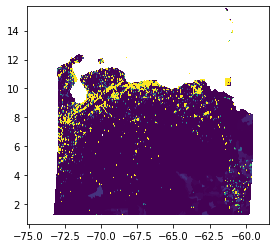

In [43]:
show(reprojected_dataset, cmap="viridis", vmax=0.5)

#### OSMNX graph

If you intend to use OSMNX library to compute the health access isolines, then you have to firstly create the Graphml object. 

In [4]:
osm_file_path = ""

# Provide shapefile path, if convert to OSM format
shp_file_path = "hotosm_ven_roads_lines_shp/hotosm_ven_roads_lines.shp"

# If convert to OSM format, then specify the ogr2osm directory
ogr2osm_path = "//root/ogr2osm"

Convert shapefile to OSM format using <i>ogr2osm</i>.

In [7]:
if shp_file_path:
    ogr2osm = os.path.join(ogr2osm_path, "ogr2osm.py")
    osm_file_path = '{0}/Roads/{0}-roads.osm'.format(country_list.value)
    
    process = subprocess.run(['python', ogr2osm, shp_file_path, '-o', osm_file_path])
    return_code = process.returncode
    
    if return_code == 0:
        print('Conversion ended successfully')
    else:
        print('Conversion failed')

Create Graphml from OSM using <i>ox.graph_from_xml()</i>

In [3]:
if osm_file_path:
    G = ox.graph_from_xml(osm_file_path, bidirectional=False, simplify=True)  

Another way to create the Graphml file is to use <i>ox.graph_from_place()</i> method to download the necessary data from the <i>Overpass API</i> and build the Graphml object based on that data. You can specify the query of the <i>Overpass API</i> to download only the types of roads that meet your criteria. More information about <i>Openstreetmap</i> roads can be found here: https://wiki.openstreetmap.org/wiki/Key:highway

In [6]:
if not osm_file_path:
    cf = '["highway"~"motorway|motorway_link|trunk|primary|secondary|tertiary"]'
    G = ox.graph_from_place(country_list.value, network_type='drive', custom_filter=cf)

Save the Graphml to disk.

In [7]:
ox.io.save_graphml(G, "{0}/Roads/{0}-roads.graphml".format(country_list.value))

#### References

* https://gadm.org/
* https://healthsites.io/
* GHS-POP Population dataset:<br>
<u>Dataset</u>: Schiavina, Marcello; Freire, Sergio; MacManus, Kytt (2019):  GHS population grid multitemporal (1975-1990-2000-2015), R2019A. European Commission, Joint Research Centre (JRC) [Dataset] doi:10.2905/0C6B9751-A71F-4062-830B-43C9F432370F PID: http://data.europa.eu/89h/0c6b9751-a71f-4062-830b-43c9f432370f <br>
<u>Concept & Methodology</u>: Freire, Sergio; MacManus, Kytt; Pesaresi, Martino; Doxsey-Whitfield, Erin; Mills, Jane (2016): Development of new open and free multi-temporal global population grids at 250 m resolution. Geospatial Data in a Changing World; Association of Geographic Information Laboratories in Europe (AGILE). AGILE 2016.